In [31]:
import os
import numpy as np
from uvplot import UVTable, arcsec, export_uvtable
from uvplot import COLUMNS_V0
import astropy.units as u
import astropy.constants as ac
import galario
from galario import deg, arcsec
from galario.double import get_image_size, check_image_size
from galario.double import chi2Profile
from galario.double import sampleProfile
from mcmc_tools import log_prior, emcee_run_wrapper, plot_corner, plot_walker
#from multiprocessing import Pool
import multiprocessing
import casatools
import casatasks

c = ac.c.to(u.m/u.s).value
pi = np.pi

tb = casatools.table()
ms = casatools.ms()

# uvplot module playground

In [221]:
# measurement set for test
msfile = "/raid/work/yamato/eDisk_data/L1489IRS/eDisk_calibrated_data/L1489IRS_SB1_continuum.ms"

# get channel number
tb.open(msfile+"/SPECTRAL_WINDOW")
nchans = tb.getcol("NUM_CHAN")
tb.close()

# split out to one channel per spw
outputvis = msfile.replace(".ms", ".split.ms")
os.system('rm -r ' + outputvis)
casatasks.split(vis=msfile, outputvis=outputvis, keepflags=False, datacolumn='data', width=nchans)

# check the number of channel in each spw
tb.open(outputvis+"/SPECTRAL_WINDOW")
freqs = tb.getcol("CHAN_FREQ")
print(freqs)
tb.close()

[[2.19959521e+11 2.19570422e+11 2.20408801e+11 2.30548565e+11
  2.31332439e+11 2.34023272e+11]]


True

In [222]:
uvtabname = "./L1489IRS_SB1_continuum.split.ms.uvtab"
export_uvtable(
    uvtabname,
    tb,
    outputvis,
    datacolumn='DATA',
#     split=casatasks.split,
#     split_args={
#         "vis": msfile,
#         "keepflags": False,
#         "datacolumn": "data",
#         "width": nchans, # average to one channel for each spw; is this ok...? Need to consider beam smearing effect?
#     },
    channel="all",
)

Reading /raid/work/yamato/eDisk_data/L1489IRS/eDisk_calibrated_data/L1489IRS_SB1_continuum.split.ms
Exporting 1 channels per spw.
Exporting visibilities to ./L1489IRS_SB1_continuum.split.ms.uvtab...done.


## Garalio playground 

In [32]:
vis = "/raid/work/yamato/eDisk_data/L1489IRS/eDisk_calibrated_data/L1489IRS_SB1_continuum.split.ms"
uvtabname = "./L1489IRS_SB1_continuum.split.ms.uvtab"

tb.open(vis)
spw = tb.getcol("DATA_DESC_ID")
tb.close()

tb.open(vis+"/SPECTRAL_WINDOW")
chan_freq = tb.getcol("CHAN_FREQ")[0]
tb.close()

freqs = np.empty_like(spw)
for i, nu in enumerate(chan_freq):
    freqs[spw == i] = nu
wle = c / freqs

ref_wle = wle.mean()

dRA = 0.    # Right Ascension offset in arcsec
dDec = 0.   # Declination offset in arcsec
inc = np.radians(73.) # Inclination    [rad]
PA = np.radians(69.) # position angle [rad]

In [12]:
vis = UVTable(filename=uvtabname, wle=ref_wle, columns=COLUMNS_V0)
vis.deproject(inc, PA)

Reading uvtable from ./L1489IRS_SB1_continuum.split.ms.uvtab ...
Assuming column format: ['u', 'v', 'Re', 'Im', 'weights']
Reading uvtable from ./L1489IRS_SB1_continuum.split.ms.uvtab ...done


Masking 22 uv bins


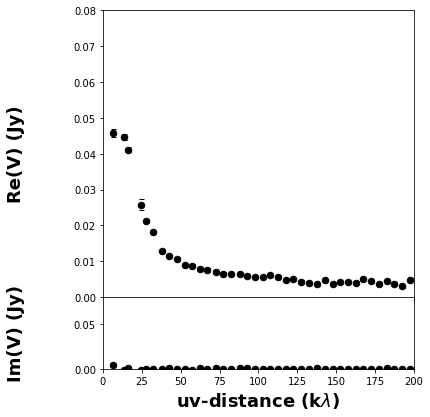

In [13]:
axes = vis.plot(uvbin_size=5e3)
for ax in axes:
    ax.set(xlim=(0,200), ylim=(0, 0.08))

In [33]:
# galario fit
# currently support only axisymmetric models 

# load observational data
u, v, Re, Im, w = np.require(np.loadtxt(uvtabname, unpack=True), requirements='C')
u /= ref_wle #np.require(wle, requirements='C')    
v /= ref_wle #np.require(wle, requirements='C')  

In [34]:
# gridding parameter
nxy, dxy = get_image_size(u, v, PB=1.22 * np.max(wle) / 12, verbose=True) # in rad
dR = 0.0012  # in arcsec
#Rmin = dxy / 100.0 / arcsec # needed to smaller than dxy for interpolation # in arcsec
Rmin = 0.0
print(Rmin)
R_pad = 2 * dxy  # padding parameter
Rmax = (dxy * nxy / np.sqrt(2) + R_pad) / arcsec
print(dxy/arcsec)#/dR/2)
# maybe better for Rmax to be larger than the coverage of nxy for interpolation + padding. need to look into the C++ source of GALARIO

dxy:1.463843e-02arcsec	nxy_MRS:2048
nxy_MRS: matrix size to have FOV > f_min * MRS, where f_min:5.0 and MRS:5.995899e+00arcsec
nxy_FOV:2048
nxy_FOV: matrix size to have FOV > PB
0.0
0.01463842501348953


In [35]:
def model_func(R, I, sigma):
    return 10 ** I * np.exp(- 0.5 * R ** 4 / sigma ** 4) 
# from van der Marel+15 (see also Sheehan+20, eDisk slack)

# generate radial grid
R = np.arange(Rmin, Rmax, dR)

# check the Nyquist criterion
duv = 1.0 / (dxy * nxy)
check_image_size(u, v, nxy, dxy, duv)

True

In [52]:
def sample_vis_1D(model_func, model_params, PA, incl, dRA=0.0, dDec=0.0):

    # generate model
    model = model_func(R, *model_params)

    # sample
    vis = sampleProfile(
        intensity=model,
        Rmin=Rmin*arcsec,
        dR=dR*arcsec,
        nxy=nxy,
        dxy=dxy,
        u=u,
        v=v,
        dRA=dRA*arcsec,
        dDec=dDec*arcsec,
        PA=PA*deg,
        inc=incl*deg,
        check=False,
    )
    
    return vis

In [60]:
param_list = ["I", "sigma", "PA", "incl", "dRA", "dDec"]
initial_state = [8.8, 2.0, 68.0, 76.0, 1e-4, 1e-4]
bound = [(0.0, 20), (0.01, 10.0), (60, 76), (68, 84), (-2.0, 2.0), (-2.0, 2.0)]


def log_likelihood(param):

    # divide into model parameters and geometrical parameters
    PA = param[param_list.index("PA")]
    incl = param[param_list.index("incl")]
    dRA = param[param_list.index("dRA")]
    dDec = param[param_list.index("dDec")]
    model_params = np.delete(
        param,
        [
            param_list.index("PA"),
            param_list.index("incl"),
            param_list.index("dRA"),
            param_list.index("dDec"),
        ],
    )

    # print(model_params)

    # smaple the model visibility
    model_vis = sample_vis_1D(
        model_func=model_func, model_params=model_params, PA=PA, incl=incl, dRA=dRA, dDec=dDec
    )

    # compute log likelihood
    rms = np.sqrt(1.0 / w)
    ll = -0.5 * np.sum(
        ((model_vis.real - Re) ** 2 + (model_vis.imag - Im) ** 2) / rms ** 2
        + np.log(2 * pi * rms ** 2)
    )

    return ll


def log_probability(param):
    lp = log_prior(param, bound)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(param)
    return lp + ll

In [66]:
nwalker = 32
nstep = 400
nburnin = 400
with multiprocessing.Pool(processes=8) as pool:
    sampler, sample = emcee_run_wrapper(
        log_probability,
        initial_state,
        nwalker=nwalker,
        nstep=nstep,
        nburnin=nburnin,
        relative_error=1e-4,
        get_sample=True,
        discard=False,
        pool=pool,
    )

starting to run the MCMC sampling with: 
 	 initial state: [8.8, 2.0, 68.0, 76.0, 0.0001, 0.0001] 
 	 number of walkers: 32 
 	 number of steps: 800 including 400 steps as burn in


100%|█████████████████████████████████████████| 800/800 [21:37<00:00,  1.62s/it]


[<Figure size 591.84x288 with 2 Axes>,
 <Figure size 591.84x288 with 2 Axes>,
 <Figure size 591.84x288 with 2 Axes>,
 <Figure size 591.84x288 with 2 Axes>,
 <Figure size 591.84x288 with 2 Axes>,
 <Figure size 591.84x288 with 2 Axes>]

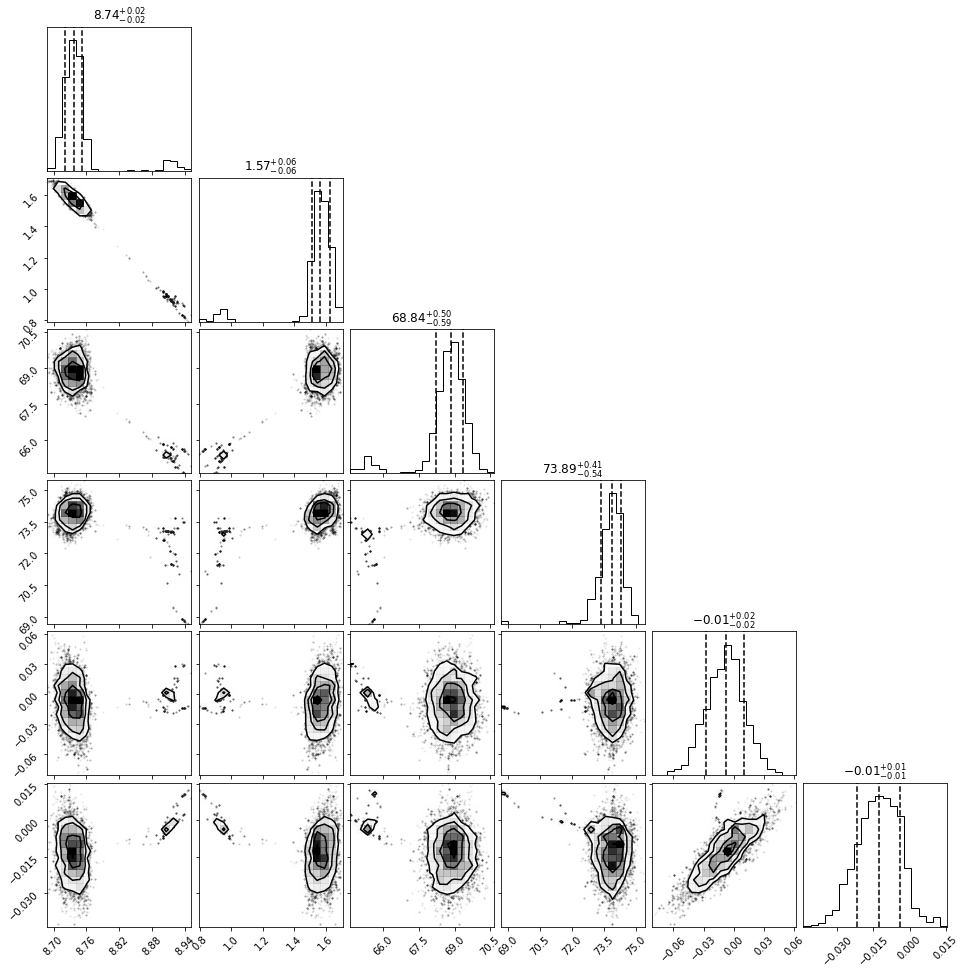

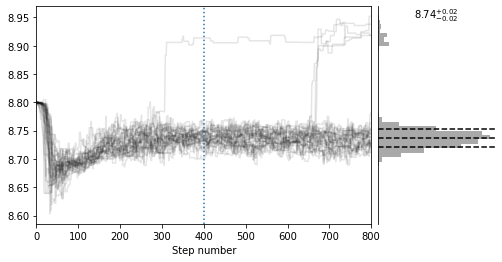

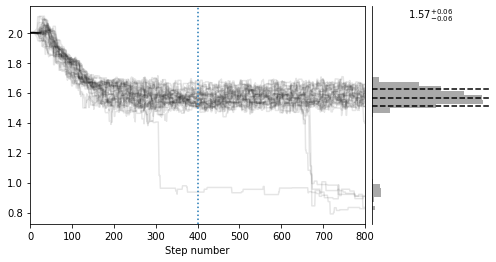

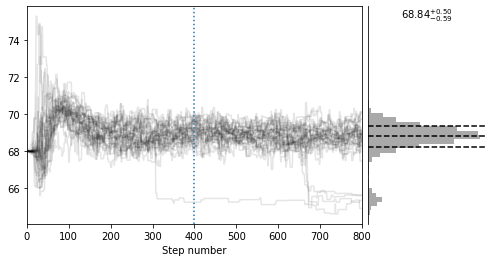

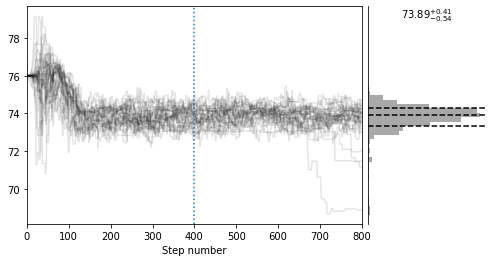

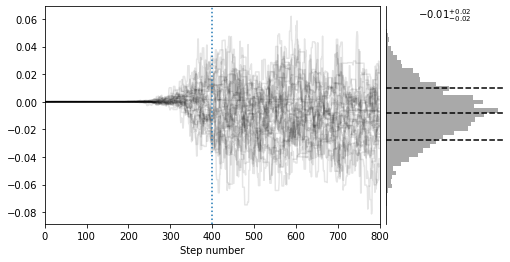

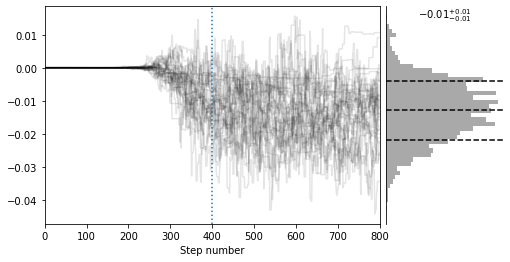

In [67]:
nburnin = 400
corner_fig = plot_corner(sample, nburnin=nburnin)
plot_walker(sample, nburnin=nburnin)